In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt


In [2]:

batch_size_train = 32
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
#log_interval = 10

random_seed = 1
torch.manual_seed(random_seed)

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./root', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./root/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
print(len(train_loader))
for a,b in train_loader:
    print(a.size())
    print(b.size())
    print(a.max())
    print(a.min())
    break

1875
torch.Size([32, 1, 28, 28])
torch.Size([32])
tensor(1.)
tensor(0.)


Hence we have loaded out MNIST dataset into the dataloaders. I haven't normalized the values as they are already within the small range of [0,1]

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #24
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #10
        x = F.dropout(x, p=0.5, training=self.training)
        #(10-5+1)/2 = 3
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        #dimensions of net -> (3,3,64)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [6]:
#Dimension check of out net

a = np.random.rand(32,1,28,28)
tensor = torch.FloatTensor(a)
print(a.shape)
print(tensor.size())
cnn(tensor).size()

(32, 1, 28, 28)
torch.Size([32, 1, 28, 28])


torch.Size([32, 10])

In [7]:
print(cnn)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [8]:
BATCH_SIZE = 32
#EPOCHS = 100

batch_losses = []

epoch_val = []
val_loss = []

optimizer = torch.optim.Adam(cnn.parameters())#,lr=0.001, betas=(0.9,0.999))
error = nn.CrossEntropyLoss()

def fit(model, train_loader,lr=0.001,epocs=10):
    EPOCHS = epocs
    epoch_accuracies = []
    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = (X_batch).float()
            var_y_batch = (y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
            
            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            total += float(len(var_y_batch))
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
        epoch_accuracies.append(correct*100/total)
        
        
        model.eval()
        loss_val = 0
        with torch.no_grad():
            correct = 0 
            total = 0
            
            for test_imgs, test_labels in test_loader:
                #print(test_imgs.shape)
                test_imgs = (test_imgs).float()
                output = model(test_imgs)
                predicted = torch.max(output,1)[1]
                correct += (predicted == test_labels).sum()
                total += float(len(test_labels))
                loss_val = error(output,test_labels)
                
            print("Test accuracy:{:.3f}% ".format( float(correct)*100 / (total)))
            epoch_val.append(correct*100/total)
            
            
    return epoch_accuracies

In [9]:
epoch_accuracies = fit(cnn,train_loader,0.001,5)

Epoch : 0 [0/60000 (0%)]	Loss: 2.313547	 Accuracy:6.250%


/home/sumeet/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch : 0 [1600/60000 (3%)]	Loss: 0.987280	 Accuracy:31.495%
Epoch : 0 [3200/60000 (5%)]	Loss: 0.598148	 Accuracy:52.290%
Epoch : 0 [4800/60000 (8%)]	Loss: 0.544468	 Accuracy:61.900%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.313215	 Accuracy:68.221%
Epoch : 0 [8000/60000 (13%)]	Loss: 0.305429	 Accuracy:72.522%
Epoch : 0 [9600/60000 (16%)]	Loss: 0.371561	 Accuracy:75.581%
Epoch : 0 [11200/60000 (19%)]	Loss: 0.423089	 Accuracy:77.947%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.091855	 Accuracy:79.536%
Epoch : 0 [14400/60000 (24%)]	Loss: 0.266190	 Accuracy:80.779%
Epoch : 0 [16000/60000 (27%)]	Loss: 0.245890	 Accuracy:82.042%
Epoch : 0 [17600/60000 (29%)]	Loss: 0.045142	 Accuracy:83.076%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.182748	 Accuracy:84.006%
Epoch : 0 [20800/60000 (35%)]	Loss: 0.085583	 Accuracy:84.769%
Epoch : 0 [22400/60000 (37%)]	Loss: 0.188364	 Accuracy:85.445%
Epoch : 0 [24000/60000 (40%)]	Loss: 0.325566	 Accuracy:85.969%
Epoch : 0 [25600/60000 (43%)]	Loss: 0.228943	 Accuracy:86.462%
E

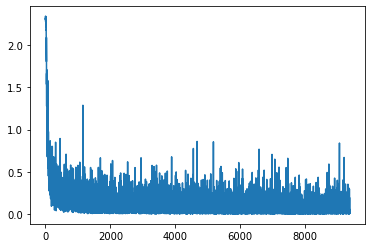

In [10]:
plt.plot(batch_losses)

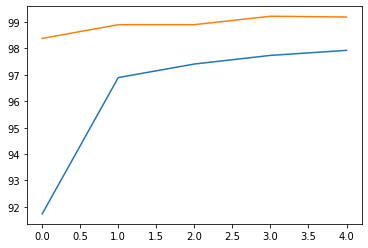

In [11]:
plt.plot(epoch_accuracies)
plt.plot(epoch_val)
#print(epoch_accuracies)
plt.show()

I haven't tried the model with different number of channels as it would take too much time to load but in general the model performs well whern the next conv layer has twice as many number of channels as the previous.

In [13]:
#validation loss vs lloss_validation_araryng rate
#done for 5 epopchs

learning_rates = [1e-5,1e-4,1e-3,1e-2,1e-1]
loss_validation_array = []

for lr in learning_rates:
    model = CNN()
    optimizer = torch.optim.Adam(model.parameters(),lr = lr)#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    print('*'*100)
    print(f"Learning Rate = {lr}")
    print('*'*100)
    loss_validation_array.append(fit(model,train_loader,lr,3))

****************************************************************************************************
Learning Rate = 1e-05
****************************************************************************************************
Epoch : 0 [0/60000 (0%)]	Loss: 2.298542	 Accuracy:18.750%
Epoch : 0 [1600/60000 (3%)]	Loss: 2.321340	 Accuracy:11.642%
Epoch : 0 [3200/60000 (5%)]	Loss: 2.294805	 Accuracy:11.726%
Epoch : 0 [4800/60000 (8%)]	Loss: 2.290753	 Accuracy:11.734%
Epoch : 0 [6400/60000 (11%)]	Loss: 2.293121	 Accuracy:11.909%
Epoch : 0 [8000/60000 (13%)]	Loss: 2.295897	 Accuracy:11.815%
Epoch : 0 [9600/60000 (16%)]	Loss: 2.315508	 Accuracy:12.033%
Epoch : 0 [11200/60000 (19%)]	Loss: 2.295540	 Accuracy:12.455%
Epoch : 0 [12800/60000 (21%)]	Loss: 2.280370	 Accuracy:12.749%
Epoch : 0 [14400/60000 (24%)]	Loss: 2.285445	 Accuracy:12.943%
Epoch : 0 [16000/60000 (27%)]	Loss: 2.287250	 Accuracy:13.498%
Epoch : 0 [17600/60000 (29%)]	Loss: 2.283514	 Accuracy:13.816%
Epoch : 0 [19200/60000 (32%)]	Loss

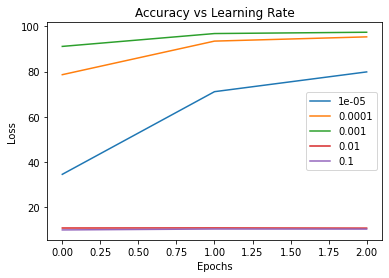

In [14]:
for i,x in enumerate(loss_validation_array):
    plt.plot(x,label = str(learning_rates[i]))

plt.title('Accuracy vs Learning Rate')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Hence, from the above graph we can conclude that the best learning rate for our model is 0.001